# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка и подготовка данных

### Исходные данные

Данные находястя в файле:    
`/datasets/autos.csv`

*Описание данных*
    
Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

    
Целевой признак
- `Price` — цена (евро)

### Импорты модулей и общие функции

In [2]:
!pip install --upgrade pip -q
!pip install --upgrade Pillow -q
!pip install -U ydata-profiling -q
!pip install -U scikit-learn -q

from time import time

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from ydata_profiling import ProfileReport

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.2.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.4 which is incompatible.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.4 which is incompatible.


In [3]:
def view_and_get_data(path, sep=None, decimal=","):
    """
    Открывает файл, выводит первые 10 строк,
    основную информцию о дата фрейме и возвращает датафрейм.
    Принимает разделить в csv файле и разделитель десятичных чисел(по умолчанию запятая).
    """
    try:
        # Пробуем открыть файл локально, если нет, то через сервер яндекса.
        data = pd.read_csv(path, sep=sep, decimal=decimal, engine='python')
    except Exception:
        print('Локальный файл не найден. Пробую открыть серверную версию файла.')
        data = pd.read_csv(f'https://не_показывать_ссылки{path}', sep=sep, decimal=decimal)
        
    display(data.head(10))
    data.info()
    return data


def hist_and_box_numeric_old(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    числовых столбцев.
    """
    columns = data.select_dtypes(exclude=['object']).columns.to_list()
    fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(10, 20))
    
    for number in range(len(columns)):
        data[columns[number]].plot(
            ax=axes[number, 0], kind="hist", ylabel=columns[number], rot=0);
        axes[number, 0].set_title(f'Гистограмма {columns[number]}')
        axes[number, 0].set_ylabel('Количество')
        axes[number, 0].set_xlabel('Значения признака')
        data[columns[number]].plot(
            ax=axes[number, 1], kind="box", ylabel='Разброс показателя', rot=0);
        axes[number, 1].set_title(f'Ящик с усами {columns[number]}')
    fig.tight_layout()

def hist_and_box_numeric(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    числовых столбцев.
    """
    columns = data.select_dtypes(exclude=['object']).columns.to_list()
    for_axis = list(zip(columns, range(0, len(columns)*2, 2)))
    fig, axes = plt.subplots(nrows=len(columns)*2, ncols=1, figsize=(10, 40))
    
    for name, number in for_axis:
        data[name].plot(
            ax=axes[number], kind="hist", ylabel=name, rot=0);
        axes[number].set_title(f'Гистограмма {name}')
        axes[number].set_ylabel('Количество')
        axes[number].set_xlabel('Значения признака')
        data[name].plot(
            ax=axes[number+1], kind="box", ylabel='Разброс показателя', rot=0, vert=False);
        axes[number+1].set_title(f'Ящик с усами {name}')
    fig.tight_layout()    

    
def hist_and_box_obj(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    категориальных столбцев.
    """
    columns = data.select_dtypes(include=['object']).columns

    if len(columns) > 1:
        columns = columns.to_list()
        fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))
        for number in range(len(columns)):
            data[columns[number]].value_counts(normalize=True).plot(
                ax=axes[number], kind='bar', xlabel=columns[number], ylabel='Доля', rot=15);
            axes[number].set_title(f'Диаграмма {columns[number]}')
        fig.tight_layout()
    else:
        columns = columns.to_list()
        data[columns[0]].value_counts(normalize=True).plot(
            kind='bar', xlabel=columns[0], ylabel='Доля', rot=15, title=f'Диаграмма {columns[0]}');

### Загрузка данных и изучение общей информации


Проведем общий анализ датафрейма.

In [4]:
data_autos = view_and_get_data('/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Попробуем использовать pandas-profiling, который уже переименовался и требует дополнительного подхода для построения отчета, но выглядит вполне внушительно.

In [ ]:
profile = ProfileReport(data_autos, title="Profiling Report")
profile

Соотвествующая библиотека позволяет провести подробный анализ датафрейма и сделать выводы.

**Выводы:**    
* Пропуски в ячейках порядка 3.2%. Для признака `VehicleType` пропусков порядка 11%. Для признака `Gearbox` порядка 6%. Для признака `Model` пропусков пордяка 6%. Для признака `FuelType` пропущенных значений порядка 9%. Для признака `Repaired` пропущенных значений уже 20%.;    
* В признаке `Price` есть множество цен равных нулю, порядка 3%. Для признака `Power` уже около 11%. Для признака `RegistrationMonth` существуют минимальные значения равные нулю, а их общее количество порядка 11%.;     
* Во рейме присутствуют 4 явных дубликата;    
* Очень смущает год регистрации 9999, скорее всего это ошибка;    
* Так же странно, что пробег в значительно степени выражается 150 000, скорее всего в данных было ограничение, что если пробег больше этого числа, то выбираем его;
* По дате создания записей анализ с 2014 года по 2016 год;
* В признаке `NumberOfPictures` все значения нули, скорее всего это новый признак, который добавили в БД недавно и еще не успели наполнить, либо изначально этого признака не было и теперь он учитывается только для новых объявлений.

### Отбор признаков для моделей

Значимые для нашей модели:

* `VehicleType` - тип автомобильного кузова - влияет на стоимость автомобиля как в большую, так и в меньшую сторону;
* `RegistrationYear` - год регистрации автомобиля - чем более новый автомобиль, тем выше цена, если подразумевается именно как "год выпуска", а не "год, когда последний владелец поставил авто на рег.учет";
* `Gearbox` - тип коробки передач - автоматическая коробка удорожает авто, поскольку её обслуживнаие, как правило, обходится дороже, но и есть свои удоства при использовании;
* `Power` - мощность в лошадиных силах - влияет на цену;
* `Model` - модель автомобиля - в зависимости от бренда, типа авто оказывает значительное влияние на цену;
* `Kilometer` - пробег (км) - чем больше пробег, тем меньше надежность авто, выше вероятность поломок и соответсвенно ниже цена;
* `FuelType` - тип топлива - в зависимости от того, какое топливо используется, будет так же влиять на конечную цену, примерно характеризовать конструкцию двигателя и его мощность;
* `Brand` - марка автомобиля - Схоже с моделью авто, но упор на конкретный бренд, всё же услашв "Ока" или "Бентли" наше первое впечатление уже складывается(если мы, конечно, слышали про них);
* `Repaired` - была машина в ремонте или нет - Если машина побывала в ДТП, то ее констукция уже видоизменена или может быть видоизменена, в зависимости от тяжести аварии может быть и значительно, следовательно надежность и качество ниже, как и цена.

На основании предыдущих выводов и отобранных признаков, имеет смысл создать новый датафрейм.

df_autos = data_autos[[
    'VehicleType', 'RegistrationYear', 'Gearbox', 'Power',
    'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Price'
]]
df_autos.info()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Делая копию или срез какой-то таблицы, стоит использовать метод `copy()`: используя простое присвивание вида `a=b`, мы в переменную `a` помещаем не новый и самостоятельный объект в памяти, а всего лишь новую ссылку на объект в памяти, на который ссылается `b`. Как итог, внеся изменения в `a`, ты увидишь их и в `b`, и наоборот. Метод `copy()` позволяет создавать именно новые объекты в памяти.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Принято, исправлено. Далее пригодился исходный датафрейм для определения даты выгрузки. Изначально изменял текущий для экономии памяти, считая, что в дальнейшем исходный не потребуется.
</div>

In [5]:
# Чтобы далее не переименовывать переменные сохраняю оригинал в отдельной переменной
df_autos_original = data_autos.copy()

df_autos = data_autos[[
    'VehicleType', 'RegistrationYear', 'Gearbox', 'Power',
    'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Price'
]]
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Поскольку мы сформировали новый фрейм, то теперь уже можем избавиться от дубликатов.

In [6]:
print("Количество явных дубликатов:", df_autos.duplicated().sum())

Количество явных дубликатов: 45040


In [7]:
df_autos = df_autos.drop_duplicates()
print("Количество явных дубликатов:", df_autos.duplicated().sum())

Количество явных дубликатов: 0


Теперь необходимо определиться с тем, как и чем заполнить пропуски.

In [8]:
pd.DataFrame(round(df_autos.isna().mean()*100,1)).style.background_gradient('cool')

,0
VehicleType,11.200000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.900000
Kilometer,0.000000
FuelType,9.900000
Brand,0.000000
Repaired,20.900000
Price,0.000000


Судя по доле пропущенных значений, исключить какие-то пропуски нельзя из-за довольно значительного их количества. Попробуем заполнить по логике и наиболее подходящим значениям.    
* `VehicleType`, `Gearbox`, `Model` заменил None на "неизвестно";
* `FuelType` заполнил как наиболее часто встречающееся для данной модели авто;
* `Repaired` была ли машина в ремонте для пустых значений установил - "нет", буду считать, что за машиной следили и ухаживали.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

В целом любая импутация пропусков сопряжена с риском внесения в модель ошибок, а удаление - с потерей обучающих примеров. При этом в случае удаления мы теряем часть бизнес-сценариев, так как ситуации, когда клиент не указывает какие-то параметры автомобиля - нередкость, и в идеале модель должна уметь обрабатывать и их.
        
При работе с категориальными признаками стоит использовать заглушки в виде новых значений категорий для заполнения пропусков: это позволит как сохранить наблюдения вместо их удаления, так и избавит нас от возможных ошибок при эмпирическом импутировании.
        

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Не особо понял этот коммент. Возможно, это отсылка к SimpleImputer? Если предположить, что далее появятся новые признаки или как-то расширятся исходные, то вместо ручного подхода лучше взять заранее автоматически спланированный(типа для пропусков None или какое-то конкретное значения во всех полях)? Идея в этом?
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Это касается правил типа `заполним как ручная, поскольку, если тип коробки не указали явно, то можно предположить, что в этом случае она наиболее распространена` - если мы явно не знаем, лучше заполнить заглушкой, чем придумывать правила для восстановления пропусков.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Ааа, понял про что ты. Спасибо!
</div>

Сначала сразу же скорректируем данные `Price` по нулевой цене, как целевому признаку.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Может быть полезно также удалить неадекватно низкие значения цен: в пределах цен до 500-1000 евро вряд ли можно купить полноценный автомобиль.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Тоже так подумал, но потом по мощности решил, вдруг какие-то старые модели. Думаю, что вполне правильно удалить спокойно авто до 500 евро.
</div>

In [9]:
df_autos = df_autos[df_autos['Price'] >= 500]

Затем вспомним, про некорректные годы регистрации `RegistrationYear`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

По верхней границе год регистрации нужно синхронизировать с датой выгрузки данных из базы: в таблице не может быть объявлений моложе даты выгрузки, иначе это были бы просто данные из будущего.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

А вот и пригодился исходный датафрейм. Понятно, зачем нужна была копия)
</div>

In [10]:
df_autos_original['DateCrawled'].max()

'2016-04-07 14:36:58'

In [11]:
df_autos = df_autos[(df_autos['RegistrationYear'] >= 1900) & (df_autos['RegistrationYear'] < 2017)]

Не забываем про мощность `Power`. Сомнительно, что продаются авто с мощностью более 1500, это довольно дорогие модели и с мощностью в ноль. Поскольку могут быть какие-то раритетные авто, то будем учитывать и низкие мощности.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Может быть полезно также удалить околонулевые значения мощности - некоторые значения этого признака в таблице напоминают, скорее, телегу с конём, чем автомобиль:)
        
Также можно было бы отсечь больше значений по верхней границе - настолько мощные значения встречаются очень редко.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Спасибо, пока еще не до конца понял баланс между тем, когда удаление помешает модельке лучше обучиться и когда можно удалять.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Со временем и опытом придёт:)

count    265059.000000
mean        117.048548
std         198.468854
min           0.000000
25%          75.000000
50%         109.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

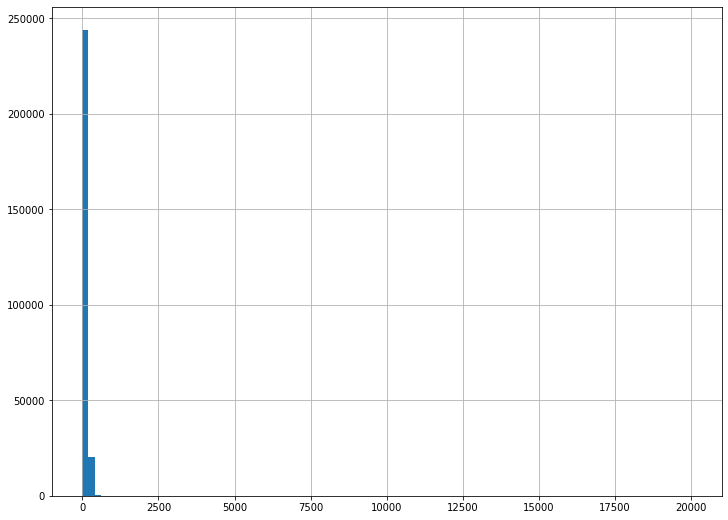

In [12]:
df_autos['Power'].hist(bins=100, figsize=(12,9))
df_autos['Power'].describe()

In [13]:
df_autos = df_autos[(df_autos['Power'] > 50) & (df_autos['Power'] <= 300)]

Заполним пропуски наиболее логичными значениями.

In [14]:
df_autos.fillna({'Gearbox': 'unknown', 'Repaired': 'no', 'Model': 'unknown', 'VehicleType': 'unknown'},
                          inplace=True)
pd.DataFrame(round(df_autos.isna().mean()*100,1)).style.background_gradient('cool')

,0
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,5.000000
Brand,0.000000
Repaired,0.000000
Price,0.000000


Остается заполнить тип топлива.

In [15]:
df_autos['FuelType'] = df_autos['FuelType'].fillna(
    df_autos.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().index[0]))
pd.DataFrame(round(df_autos.isna().mean()*100,1)).style.background_gradient('cool')

,0
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,0.000000
Price,0.000000


In [ ]:
model_profile = ProfileReport(df_autos, title="Profiling Report before modelling")
model_profile

**Вывод:**    
* Данные проанализированы;
* Заполнены пропуски;
* Убраны дубликаты;
* Отобраны наиболее критичные признаки для построения моделей;
* Обработаны аналомалии, выбросы;
* Данные подготовлены к этапу моделирования.

## Обучение моделей

По заданию обязательно требуется использовать LightGBM, и как минимум одну модель — не бустинг. Возьмём стандартно LinearRegression. Логику данного проекта я вообще не понял, потому что на бустинге завалили просто формулами и материал подан так, словно я не изучаю бустинг, а просто вспоминаю, что это. Понял ли я что-то? Абсолютно нет. Прям как на уроке геометрии - формул давали кучу, а практическое применение в задачах сразу в процессе, без объяснения смысла и вообще зачем. Окей, делим данные на порции, вроде бы потом усредняем и получаем более точные предсказания. Хорошо, а какие прочие модели использовать: лучше лес? Может SVC? С кем обычно конкурирует бустинг на практике? Когда мы решаем, что "ну всё...дальше только бустинг." Или мы от скуки "а почему бы не использовать бустинг?..хм, или лучше заказать пиццу?" И я как-то пропустил использовании функции dot и операции с векторами в последнее время, вроде пару месяцев назад было. Очень сырая теория. У меня не появилось даже идеи о том, для каких моделей и в каких ситуациях бустинг лучше использовать, но если мне нужны будут формулы без закрепления, то можно будет полистать этот спринт. Поэтому идем по минималке: требования заказчика и по классике линейная регрессия. Я бы сказал окей, я что-то узнал, когда нужно будет, то разберусь. Скорее всего позже просто посмотрю видосы и статьи на тему бустинга и его применения. Если сочтете, что нужно больше моделей и какие-то обязательно, то не вопрос - поправлю после ревью.
    
Для начала кодируем и масштабируем данные. 

### Масштабирование и кодирование признаков

In [16]:
def year_in_category(year):
    """Возвращает категорию вместо года."""
    if year < 2000:
        return 'до 2000'
    if year < 2010:
        return 'до 2010'
    return 'после 2010'


RANDOM_STATE=4221
TEST_SIZE=0.40

# После ревью переводим два признака в категориальные
df_autos['Kilometer_category'] = df_autos['Kilometer'].apply(
    lambda x: 'менее 150 тыс.' if x < 150000 else 'более 150 тыс')
df_autos['RegistrationYear_category'] = df_autos['RegistrationYear'].apply(
    year_in_category)


features = df_autos.drop(['Price', 'Kilometer', 'RegistrationYear'], axis=1)
target = df_autos['Price']

# Разбиваем на группы
X_train, X_test, y_train, y_test = train_test_split(
            features,
            target,
            random_state=RANDOM_STATE,
            test_size=TEST_SIZE
        )
#X_test, X_valid, y_test, y_valid = train_test_split(
#            X_test,
#            y_test,
#            random_state=RANDOM_STATE,
#            test_size=0.5
#        )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')  # X_valid.shape,y_valid.shape,

(139848, 9)
(93232, 9)
(139848,)
(93232,)


Определяем категориальные и количественные признаки

In [17]:
cat_col_names = features.select_dtypes(['object']).columns.to_list()
print('cat_col_names =', cat_col_names)
num_col_names = features.select_dtypes(exclude=['object']).columns.to_list()
print('num_col_names =', num_col_names)

cat_col_names = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'Kilometer_category', 'RegistrationYear_category']
num_col_names = ['Power']


In [18]:
df_autos.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price,Kilometer_category,RegistrationYear_category
1,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,18300,менее 150 тыс.,после 2010
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no,9800,менее 150 тыс.,до 2010
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500,более 150 тыс,до 2010
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600,менее 150 тыс.,до 2010
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,650,более 150 тыс,до 2000


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
`Kilometer` и `RegistrationYear` имеет распределение категориального признака, так как задано небольшое количество уникальных значений - с ним также стоит работать как с категорией.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Принято, тогда выделю на их основе категориальные признаки. Добавил категориальные признаки и убрал из фрейма исходные числовые. 
</div>

Масштабирует числовые признаки, и кодирует категориальные.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>

Для древесных моделей и моделей на бустингах не стоит использовать `OneHotEncoder()` или его аналог `get_dummies()`: эта техника кодирования увеличивает количество признаков, в результате чего модели сложнее создавать разделяющие правила, поэтому время работы и расчётные характеристики моделей сильно страдают на больших наборах данных. Вместо этого нужно использовать `OrdinalEncoder()` - эта техника кодирует категориальные признаки так, что с ними удобнее работать в ходе создания разделяющих правил. 
    
Для бустинговых алгоритмов альетрнатинва - использование внутренних кодировщиков, которые работают лучше сторонних. В случае `CatBoost` за это отвечает параметр `cat_features`. В случае `LightGBM` можно привести эти категориальные признаки к типу `category`, тогда модель будет работать с категориальными признаками автоматически.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Понимаю про что ты и почему рекомендуешь OrdinalEncoder. Частично этот вопрос задавал на ревью предыдущего проекта, но теперь немного запутался. Смотри, мне ревьюр давал такую рекомендацию: "'last_year_promo' и 'last_year_violations' - непорядковые признаки, их нужно перенести в ohe_col. При порядковом кодировании мы ранжируем значения категоиального признака: 1,2,3... Это логично для тех признаков, в которых есть естественный порядок, например, размеры одежды S, M, L, XL. А если этого порядка нет, линейные модели будут обучаться не совсем корректно".    
    
Я использую OrdinalEncoder, вероятно есть какие-то признаки для OneHotEncoder?
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Порядок при `OrdinalEncoder` важен для линейных моделей, поэтому `OrdinaLEncoder` для линейной модели имеет место применять для упорядоченных признаков, для нелинейных моделей упорядоченность признаков не важна, поэтому все признаки можно кодировать `OrdinalEncoder`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `OneHotEncoder` нужно настроить так, чтобы он обрабатывал новые значения признаков, а не выбрасывал ошибку - при текущей настройке `handle_unknown` в случае возникновения новых значений у признаков, которых не было в `train`, модель будет падать, а для многих случаев важна бесперебойность решений.
    
Может понадобиться обновление библиотеки `sklearn`, так как в ранних версиях параметры `handle_unknown` и `drop` конфликтовали друг с другом, но в актуальной версии библиотеки такой проблемы нет.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправлено ниже, в случае возникновения ошибки, игнорируем её.
</div>

In [19]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [20]:
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
#X_valid_ohe = encoder.transform(X_valid[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
        
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
#X_valid_scaled = scaler.transform(X_valid[num_col_names])
        
# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
#X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
#X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
#X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

### LinearRegression

In [34]:
lmodel = LinearRegression()
param_grid = {'n_jobs': [-1]}

gs_lmodel = GridSearchCV(lmodel, param_grid, scoring='neg_mean_squared_error')
gs_lmodel.fit(X_train, y_train)

GridSearchCV(estimator=LinearRegression(), param_grid={'n_jobs': [-1]},
             scoring='neg_mean_squared_error')

In [22]:
%%time
rmse_lmodel = ((gs_lmodel.best_score_)*-1)**0.5
print('RMSE на кросс-валидации для Линейной модели', rmse_lmodel)

RMSE на кросс-валидации для Линейной модели 2933.120782982381
CPU times: user 574 µs, sys: 93 µs, total: 667 µs
Wall time: 144 µs


In [23]:
best_gs_lmodel = gs_lmodel.best_estimator_
start_lr_learn = time()
best_gs_lmodel.fit(X_train, y_train)
end_lr_learn = time()
learn_lr_time = (end_lr_learn - start_lr_learn) / 60
print('Время на обучение модели LinearRegression(мин):', learn_lr_time)

Время на обучение модели LinearRegression(мин): 0.0003204743067423503


In [24]:
start_lr_pred = time()
preds_lmodel = best_gs_lmodel.predict(X_train)
end_lr_pred = time()
pred_lr_time = (end_lr_pred - start_lr_pred) / 60
print('Время на предсказание модели LinearRegression(мин):', pred_lr_time)

Время на предсказание модели LinearRegression(мин): 0.0010193506876627603


rmse_lmodel = mean_squared_error(y_valid, preds_lmodel, squared=False)
print("RMSE LinearRegression =", round(rmse_lmodel, 2))

**переведено в комментарий по причине**: /opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

rmse_lmodel = root_mean_squared_error(y_train, preds_lmodel)
print("RMSE LinearRegression =", round(rmse_lmodel, 2))

**Вывод:**
Линейная модель выдает метрику качества ниже, чем требует заказчик(RMSE меньше 2500).

### LGBMRegressor

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Гиперпараметры, у которых в сетке только одно значение, корректнее сразу настраивать при инициализации модели и не вносить в сетку: основная идея перебора - исследование нескольких значений, а когда значение одно, то и перебор фактически не происходит.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Хотя бы для одной модели нужно выполнить оптимизацию не менее двух гиперпараметров. Фактически для гиперпараметра `learning_rate` нет диапазона перебора, а `random_state` в идеале в сетку не нужно передавать в принципе, поэтому фактически выполняется оптимизация только одного гиперпараметра.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Принято, ниже поправлено.
</div>

In [25]:
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)
params = [{
    'num_leaves':[50, 100], 
    'learning_rate':[0.1, 0.3]}]

In [26]:
%%time

lgbm = GridSearchCV(lgbm_model, params, scoring='neg_mean_squared_error')
lgbm.fit(X_train, y_train)
print(lgbm.best_params_)

{'learning_rate': 0.3, 'num_leaves': 100}
CPU times: user 7min 29s, sys: 1.35 s, total: 7min 30s
Wall time: 7min 31s


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В проекте используется `GridSearchCV` с встроенной кросс-валидацией - нужно выбрать единый подход к промежуточной оценке моделей: кросс-валидация или валидационная выборка. 
    
Два подхода одновременно использовать не принято: при выделении `valid` мы теряем часть наблюдений из `train`, далее, проводя кросс-валидацию, при делении на фолды часть наблюдений из `train` также отходит для формирования оценочного фолда, в результате чего модель может не совсем качественно обучиться.

<div class="alert alert-info">
<h2> Комментарий студента v.2 <a class="tocSkip"> </h2>

Теперь понял, поправил.
</div>

In [27]:
%%time
rmse_lgbm = ((lgbm.best_score_)*-1)**0.5
print('RMSE на кросс-валидации', rmse_lgbm)

RMSE на кросс-валидации 1957.8585191834525
CPU times: user 280 µs, sys: 2 µs, total: 282 µs
Wall time: 181 µs


In [28]:
%%time
better_lgbm = lgbm.best_estimator_
print(better_lgbm)

LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=4221)
CPU times: user 0 ns, sys: 460 µs, total: 460 µs
Wall time: 469 µs


Примерный результат.
{'learning_rate': 0.3, 'num_leaves': 100}
RMSE на кросс-валидации -3889575.0762974834
LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=4221)
CPU times: user 14min 54s, sys: 5.53 s, total: 15min
Wall time: 15min 7s

In [29]:
%%time

start_lgbm_learn = time()
better_lgbm.fit(X_train, y_train)
end_lgbm_learn = time()
learn_lgbm_time = (end_lgbm_learn - start_lgbm_learn) / 60
print('Время на обучение модели LGBMRegressor(мин):', learn_lgbm_time)

Время на обучение модели LGBMRegressor(мин): 0.10798962910970052
CPU times: user 6.4 s, sys: 63.7 ms, total: 6.47 s
Wall time: 6.48 s


In [30]:
%%time

start_lgbm_pred = time()
lgbm_predict = lgbm.predict(X_train)
end_lgmb_end = time()
pred_lgbm_time = (end_lgmb_end - start_lgbm_pred) / 60
print('Время на предсказание модели LGBMRegressor(мин):', pred_lgbm_time)

Время на предсказание модели LGBMRegressor(мин): 0.016929046312967936
CPU times: user 1 s, sys: 2.79 ms, total: 1 s
Wall time: 1.02 s


**Вывод:**
* Были отмашстабированы и закодированы признаки;
* Были обучены две модели LinearRegression и LGBMRegressor.

## Анализ моделей

In [31]:
results = pd.DataFrame({
    'Название модели': ['LinearRegression', 'LGBMRegressor'],
    'Метрика RMSE': [rmse_lmodel, rmse_lgbm],
    'Затраченное время на обучение, мин': [learn_lr_time, learn_lgbm_time],
    'Затраченное время на предсказание, мин': [pred_lr_time, pred_lgbm_time],
    'Перебор параметров': [False, True],
    'Метрика отвечает требования заказчика': [
        'Нет' if rmse_lmodel > 2500 else 'Да',
        'Нет' if rmse_lgbm > 2500 else 'Да']
})
results

,Название модели,Метрика RMSE,"Затраченное время на обучение, мин","Затраченное время на предсказание, мин",Перебор параметров,Метрика отвечает требования заказчика
0,LinearRegression,2933.120783,0.00032,0.001019,False,Нет
1,LGBMRegressor,1957.858519,0.10799,0.016929,True,Да


Требуемый уровень метрики достигает модель с бустингом, стандартная линейная регрессия не дотягивает до необходимого уровня не более 2500. При этом ожидание на обучение модели с бустингом примерно в 8 раз больше.

**Вывод:**
~~Модели с бустингом позволяют достичь лучшей метрики качества за счет порционности, но требуют гораздо больше времени на обучение. Так же не позволяют менять слишком большое количество гиперпараметров, поскольку это так же скажется на времени обучения в худшую сторону. ~~    

Видно, что модель линейной регрессии не дотягивает по метрике качества до требуемой заказчиком. По затраченному времени на обучение и предсказание линейная регрессия лучше: по скорости обучения в 18,9 раз, по скорости предсказания в 3,7 раз. Однако общая скорость затраченная на обучение незначительна, поэтому возможно и нужно использовать модель `LGBMRegressor`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

По этому блоку будет несколько важных замечаний:
1. Все модели этого блока оцениваются на тестовой выборке - это преждевременное решение, так как оценка на тестовой выборке - это финальное тестирование для лучшей модели, которая была отобрана в ходе промежуточного тестирования. Эта концепция находит своё отражение в условиях эксплуатации модели в реальной среде: в промышленной эксплуатации не работает несколько моделей одновременно - в промышленную эксплуатацию запускают только одну модель, которая была выбрана из нескольких в ходе промежуточной оценки. Так же и здесь - тестовая выборка имитирует поток реальных данных, и с этим потоком должна работать только одна модель. 


2. Лучшая модель должна быть выбрана по двум критериям - метрика `RMSE` и время работы модели. Далее сценарий работы с моделями в этом блоке зависит от выбранной стратегии валидации и оптимизации гиперпараметров:
- для оптимизации гиперпараметров и промежуточной оценки моделей была выделена валидационная выборка;
- для оптимизации гиперпараметров и промежуточной оценки моделей проводится кросс-валидация.
    
    В первом случае метрика промежуточной оценки модели - это метрика `RMSE` на валидационной выборке, полученная от использования на `valid` лучшей модели, а время - это время обучения модели с лучшими гиперпарметрами на `train` и время совершения ею предсказаний на `valid`.
    
    Во втором случае метрика промежуточной оценким модели - это метрика `RMSE` с кросс-валидации: в случае использования `cross_val_score` - это среднее из массива метрик (длина соответствует количеству фолдов для кросс-валидации), который возвращает инструмент, в случае использования `GridSearchCV` или `RandomizedSearchCV` - это метрика из атрибута `best_score_`. Временем работы лучшей модели может быть время обучения на `train` и время предсказания на `train` выборке (только время, метрика `RMSE` на тренировочной выборке не нужна).
    
    Тут часто студенты делают ошибку, принимая в качестве метрики времени время работы лучшей модели, а время оптимизации гиперпараметров в целом (то есть время выполнения всей ячейки кода цикла с `cross_val_score` или ячейки с `GridSearchCV`) - это некорректный подход: на практике модель не будет каждый раз переобучаться и выполнять оптимизацию гиперпараметров перед очередным предсказанием - сначала будет найдена лучшая модель, а она уже будет использоваться для обучения и предсказаний. Поэтому и в этом случае сначала определяется лучшая модель, а уже потом замеряется время её работы: кросс-валидации как альтернатива времени обучения и предсказания (потому что по сути кросс-валидация объединяет в себе обучение и предсказание) или время обучения и предсказания на `train`.
    
    Независимо от выбранной стратегии кросс-валидации алгоритм работы выглядит как:
- оптимизация гиперпараметров и поиск лучшей модели;
- оценка метрики `RMSE`;
- оценка времени работы лучшей модели: на валидационной выборке (если она выделялась) или на кросс-валидации/тренировочной выборке (если проводилась кросс-валидация).
    
Концепт для `valid`:
    
    for ... in ...:
    
        #код для поиска лучшей модели
    
    model = ... #код для инициализации лучшей модели с оптимальными гиперпараметрами
    
    model.fit(X_train, Y_train) #замеряем время обучения
    
    pred = model.predict(X_valid) #замеряем время предсказания
    
    RMSE = (Y_valid, pred) #замеряем RMSE на valid
    
Концепт для кросс-валидации:
    
    model = #инициализируем модель
    gs = GridSearchCV(...) #настраиваем поиск по сетке
    
    gs.fit(...) #находим лучшую модель
    
    gs.best_score_ #замеряем RMSE на  кросс-валидации
    
    model = gs.best_estimator_ #получаем лучшую модель из best_estimator
    model = #YourModel(random_state = 42, **gs.best_params) #альтернативный способ получения лучшей модели
    
    model.fit(X_train, Y_train) #замеряем время обучения
    model.predict(X_train) #замеряем время предсказания
    
    
   По итогу нужно будет провести сравнительную характеристику моделей по критериям метрики `RMSE` и времени работы моделей и выбрать лучшую - именно эта лучшая модель должна будет оцениваться на тестовой выборке.
    
   Обрати также внимание, что при создании таблицы нельзя использовать вручную введённые значения - они потеряют актуальность при любом изменении в данных, их обработке или в моделях. Значения метрик лучше помещать в переменные и использовать их для создания таблиц. Для сохранения в переменные времени работы моделей можно использовать модуль `time`:
    
    from time import time
    
    start = time()
    
    #код модели
    
    end = time()
    
    model_time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды
    
3. Итоговый вывод нужно поправить.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Спасибо, принято. Перепишу исходное под требования.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Актуален п.2 - нужно выбрать единый подход к промежуточной оценке и немного переделать модельный блок.

<div class="alert alert-info">
<h2> Комментарий студента v.2 <a class="tocSkip"> </h2>

Понял, фактически можно добавить в линейной регрессии такой же подход как к `LGBMRegressor`.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Остался момент с обучением модели: ты замеряешь время поиска `best_estimator_`, а нам нужно замерить время его обучения уже после того, как он был найден.

<div class="alert alert-info">
<h2> Комментарий студента v.3 <a class="tocSkip"> </h2>

Точно, для линейной модели я что-то затупил. Если я правильно понял) Там я замерял время в процессе поиска. Хм, много ошибаюсь в мелочах - плохо, но работаю над этим. Попробую выработать какую-нибудь стратегию на будущее, чтобы свести такие моменты до минимума. Спасибо!
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Теперь верно, да. Не переживай на счёт путаницы - тема очень непростая, поэтому нужно много времени, чтобы в ней разобраться, особенно с этими тонкостями по метриками времени. Но ты хорошо справился:)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

### Проверка модели на адекватность

In [32]:
lgbm_predict_test = lgbm.predict(X_test)
rmse_lgbm_test = root_mean_squared_error(y_test, lgbm_predict_test)
print("RMSE DummyRegressor =", round(rmse_lgbm_test, 2))

RMSE DummyRegressor = 1960.83


Проверим модель на адекватность. Насколько она предсказывает лучше чем DummyRegressor.

In [33]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
rmse_dum_model = root_mean_squared_error(y_test, y_predict_dummy_mean)
print("RMSE DummyRegressor =", round(rmse_dum_model, 2))

RMSE DummyRegressor = 4618.07


**Вывод:** Как видно из результатов модель `LGBMRegressor` даёт необходимое для заказчика качество и по требуемой метрики выше чем линейная регрессия. Проверка на адекватность также пройдена, что говорит о том, что использование данной модели эффективнее, чем просто взять среднее.